In [2]:
import pandas as pd
import numpy as np

### Clean the UNHCR dataset
To clean the UNHCR data, I:
- Drop duplicate rows for Antigua and Barbuda
- Replace non contiguous values with contiguous values where necessary
- Remove problematic observations based on SuddenREFROCDecreases.xlsx - provided by Geraldine.

In [357]:
# remove duplicate rows
df = pd.read_csv('raw/data.csv',engine='pyarrow').drop_duplicates(['Id','year']).drop('', axis=1)

# replace contig values that should be ones but are zeros
df.loc[df.Id.isin(['CODUGA','UGACOD','SDNSSD','SSDSDN','SSDETH','ETHSSD','SSDUGA','UGASSD','CODCOG','COGCOD','CAFCOD','CODCAF','CODBDI','BDICOD','SSDKEN','KENSSD','SSDCOD','CODSSD','CODZMB','ZMBCOD',]), 'contig'] = 1

# remove problematic observations
df.loc[(df.Id == 'CODAGO') & df.year.isin([2017, 2018]), 'newarrival'] = np.nan

df.loc[df.Id == 'AFGIRN', 'newarrival']= np.nan

df.loc[df.Id == 'AFGPAK', 'newarrival'] = np.nan

df.loc[df.Id == 'ERTSDN', 'newarrival']= np.nan

df.loc[(df.Id == 'SYRTUR') & (df.year > 2018), 'newarrival']= np.nan

# remove anything after 2021
df = df[df.year <= 2021]

df.to_csv('clean/unhcr.csv', index=False)

### Cleaning the Migration data
This migration stock data comes from [Our World in Data](https://ourworldindata.org/migration#explore-data-on-where-people-migrate-from-and-to)
It is every five years from 1990 to 2020.

- I read the data in
- Add 2021
- Melt it to long format
- I forward fill the data because these migration stocks are only released every five years.
- Use country converter to convert names to iso 3 codes.

In [435]:
df = pd.read_csv('raw/migration-flows.csv', engine='pyarrow').rename({'Year':'year'},axis=1)
df = df.loc[:,~df.columns.str.contains('_origin|_destination')]
df = df[df.year >= 2000]

df['year'] = pd.to_datetime(df.year, format='%Y')

df_2021 = df[df.year == pd.to_datetime('2020', format='%Y')].copy()

# change 2020 to 2021
df_2021['year'] += pd.Timedelta(366, unit='d')

# concatenate 2021 w/ rest
df = pd.concat([df, df_2021], axis=0)

I melt the data frame, and fill in missing years.

In [436]:
# melt df, split Emigrants Immigrants columns, filter out rows with same origin and destination
df = df.melt(id_vars=['Country','year'], var_name='Country_d').rename({'Country':'Country_o'}, axis=1).fillna(0)
df[['EmigrantsImmigrants', 'Country_d']] =  df.Country_d.str.split(' from | to ', expand=True)
df = df[(df.Country_d != df.Country_o)]

# for values that say emigrants, switch the origin with destination
emigrants_mask = df['EmigrantsImmigrants'] == 'Emigrants'
df.loc[emigrants_mask, ['Country_o', 'Country_d']] = df.loc[emigrants_mask, ['Country_d', 'Country_o']].values

df = df[['year', 'Country_o', 'EmigrantsImmigrants', 'Country_d', 'value']].drop('EmigrantsImmigrants', axis=1).drop_duplicates(['year','Country_o','Country_d'])
df.value = df.value.abs()

Country long names get replaced with iso 3 short names using country converter.

In [437]:
# convert the country names to iso3
import country_converter as coco
iso3_unique = coco.convert(names=df.Country_o.unique(), to='ISO3')
iso_3_dict = dict(zip(df.Country_o.unique(), iso3_unique))

df[['Country_o','Country_d']] = df[['Country_o','Country_d']].apply(lambda x: x.map(iso_3_dict))
df.rename({'Country_o':'iso_o','Country_d':'iso_d', 'value':'migration_stock'}, axis=1,inplace=True)

Caribbean not found in regex
Channel Islands not found in regex
Polynesia not found in regex


In [438]:
# I convert stock data to the percent of migrants both from the perspective of the origin country and destination country.
unhcr_data = pd.read_csv('clean/unhcr.csv', engine='pyarrow')[['iso_o','iso_d','year','pop_o','pop_d']].drop_duplicates(['iso_o','iso_d','year'])

In [439]:
df.rename({'year':'Year'}, inplace=True, axis=1)
df['year'] = df.Year.dt.year

In [440]:
df = unhcr_data.merge(df, on=['iso_o','iso_d','year'], how='left')
df[['migration_stock_pct_o','migration_stock_pct_d']] = df[['pop_o','pop_d']].apply(lambda x: df.migration_stock/(x*1000))

In [442]:
df = df.drop(['pop_o','pop_d','Year'],axis=1).rename({'Year':'year'},axis=1)

In [443]:
# fill in missing years.
df = df.set_index(['year','iso_o','iso_d']).groupby(['iso_o', 'iso_d']).fillna(method='ffill')
# df['years_since_migration_report'] = df.index.get_level_values('year').year % 5
df.reset_index(inplace=True)

In [446]:
# write to csv
df.to_csv('clean/migration_stocks.csv', index=False)

### Cleaning IDP data 

This IDP data on internally displaced people comes from the IDMC https://www.internal-displacement.org/database/displacement-data.

It is yearly from 2008 to 2022, and contains data on both the stock of internally displace peoples and the new amount that year.

As a prior, let's say that disaster idp is irrelevant to refugee newarrivals and drop disaster idp data.

In [259]:
# read in an rename columns
idp_df = pd.read_excel('raw/IDMC_Internal_Displacement_Conflict-Violence_Disasters.xlsx').rename({'Year':'year','Name':'Country','ISO3':'iso','Conflict Stock Displacement (Raw)':'conflict_stock_idp', 'Conflict Internal Displacements (Raw)':'conflict_idp',
       'Disaster Internal Displacements (Raw)':'disaster_idp',
       'Disaster Stock Displacement (Raw)':'disaster_stock_idp'}, axis=1).drop(['Country','Conflict Stock Displacement','Conflict Internal Displacements','Disaster Internal Displacements','Disaster Stock Displacement', 
       'disaster_stock_idp','disaster_idp'], axis=1)

unhcr_data = pd.read_csv('raw/data.csv', engine='pyarrow')[['iso_o','year','pop_o']].drop_duplicates(['iso_o','year'])
newarrival_o = pd.read_csv('raw/data.csv', engine='pyarrow').groupby(['iso_o','year']).newarrival.sum().reset_index()
unhcr_data = unhcr_data.merge(newarrival_o, on=['iso_o','year'], how='left')

In [260]:
merged_idp = unhcr_data.merge(idp_df, how='left', left_on=['iso_o','year'], right_on=['iso','year']).drop('iso',axis=1)
#merged_idp['disaster_pct'] = (merged_idp.disaster_idp/merged_idp.pop_o/1000000)

There is a significant amount of data that are missing in the idp data:

In [261]:
print('proportion missing')
merged_idp.isna().sum() / merged_idp.shape[0]

proportion missing


iso_o                 0.000000
year                  0.000000
pop_o                 0.000000
newarrival            0.000000
conflict_stock_idp    0.852041
conflict_idp          0.864694
dtype: float64

Can we assume that this data is missing because the values should be zero?

In [262]:
# number of rows where conflict data is missing AND the number of refugees is greater than 10,000 AND the year is greater than equal to 2008
merged_idp[merged_idp.conflict_idp.isna() & (merged_idp.newarrival > 1000) & (merged_idp.year >= 2008)].sort_values(by='newarrival', ascending=False)

,iso_o,year,pop_o,newarrival,conflict_stock_idp,conflict_idp
4768,VEN,2018,28.903,2508056.5,NaN,NaN
4769,VEN,2019,27.817,1524435.0,NaN,NaN
4771,VEN,2021,27.586,664573.0,NaN,NaN
4770,VEN,2020,27.951,572356.0,NaN,NaN
3933,SOM,2008,11.400,150764.0,NaN,NaN
...,...,...,...,...,...,...
2965,MOZ,2015,27.042,1005.0,NaN,NaN
3566,ROU,2016,19.761,1004.0,NaN,NaN
3011,NAM,2011,2.116,1003.0,NaN,NaN
4760,VEN,2010,28.524,1002.0,NaN,NaN


In [263]:
# number of rows where the number of refugees is greater than 10,000 AND the year is greater than equal to 2008
merged_idp[(merged_idp.newarrival > 1000) & (merged_idp.year >= 2008) ]

,iso_o,year,pop_o,newarrival,conflict_stock_idp,conflict_idp
8,AFG,2008,22.997,29698.0,NaN,NaN
9,AFG,2009,23.596,41719.0,297000.0,0.0
10,AFG,2010,24.269,38424.0,352000.0,102000.0
11,AFG,2011,25.031,45420.0,450000.0,186000.0
12,AFG,2012,25.864,60632.0,492000.0,100400.0
...,...,...,...,...,...,...
4891,ZWE,2016,14.228,9435.0,NaN,NaN
4892,ZWE,2017,14.437,4523.0,NaN,NaN
4893,ZWE,2018,14.642,1908.0,NaN,NaN
4894,ZWE,2019,14.905,3371.0,NaN,NaN


It seems that that half of the 1/2 of the outflows where the total number of outflows is greater than 1,000 are missing. This means that missing data isn't simply zero, and it actually is missing data.

We'll need to convert this to some sort of categorical variable if we want to use it.

Here is the current approach. Where we do $$log(\frac{conflict\_variable}{population \text{ (in 1000s)}} + .0001)$$

The .0001 is to ensure that an error is produced.

In [264]:
merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']] = merged_idp[['conflict_stock_idp', 'conflict_idp']].apply(lambda x: np.log((x/ (merged_idp.pop_o * 1000))+.0001))

When we do this, we get a distribution where the values are mostly between -6 and 6. The most common value before was zero, which is what the value to the left of -8 is.

<Axes: >

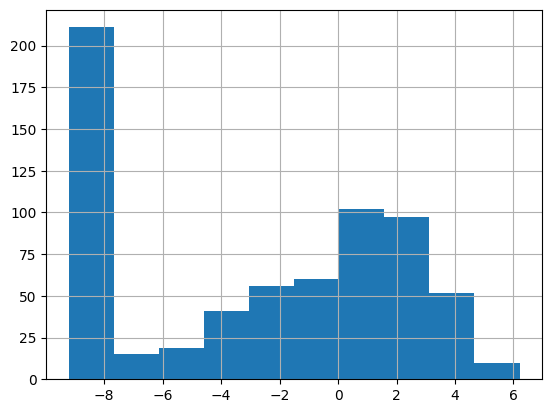

In [266]:
merged_idp.conflict_idp_pop.hist()

To convert to categorical variable, we first convert to a string.

In [268]:
merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']] = merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']].apply(lambda x: np.round(x).astype(str))
merged_idp.drop(['pop_o','newarrival','conflict_stock_idp','conflict_idp'], axis=1, inplace=True)

Then we do binary encoding.

In [274]:
from category_encoders.binary import BinaryEncoder
be = BinaryEncoder()
idp_binary = be.fit_transform(merged_idp[['conflict_stock_idp_pop', 'conflict_idp_pop']])
idp_binary = pd.concat([merged_idp.drop(['conflict_stock_idp_pop', 'conflict_idp_pop'], axis=1), idp_binary],axis=1)

idp_binary.sample(10)

,iso_o,year,conflict_stock_idp_pop_0,conflict_stock_idp_pop_1,conflict_stock_idp_pop_2,conflict_stock_idp_pop_3,conflict_stock_idp_pop_4,conflict_idp_pop_0,conflict_idp_pop_1,conflict_idp_pop_2,conflict_idp_pop_3,conflict_idp_pop_4
1412,SWZ,2012,0,0,0,0,1,0,0,0,0,1
3905,SLB,2005,0,0,0,0,1,0,0,0,0,1
502,BTN,2002,0,0,0,0,1,0,0,0,0,1
1714,GTM,2014,0,0,0,1,0,0,1,1,0,1
1258,ECU,2008,0,0,0,0,1,0,0,0,0,1
3702,SAU,2002,0,0,0,0,1,0,0,0,0,1
2993,MMR,2018,0,1,0,1,1,0,0,1,1,0
1121,CYP,2021,0,1,1,1,0,0,0,0,0,1
3337,PAN,2012,0,0,0,0,1,0,0,0,0,1
1241,DOM,2016,0,0,0,0,1,0,0,0,0,1


The result is 4 columns for each variable, where the values ranging from -8 to 6 or so have been encoded. The missing nan has also been encoded as a unique variable.

In [ ]:
idp_binary.to_csv('clean/idp.csv')

### Fragile States Index

From [here](https://fragilestatesindex.org/)

It is yearly from 2006-2022 and contains info on 179 countries.

In [447]:
# load excel files in
import os
path = 'raw/fsi 2022-2006/'
fsi_files = os.listdir(path)
fsi_files = path + pd.Series(fsi_files)
fsi_df = pd.concat(fsi_files.apply(lambda x: pd.read_excel(x)).tolist())

In [448]:
# rename columns
fsi_df = fsi_df.rename({'Year':'year', 'Total':'fsi_overall', 'C1: Security Apparatus':'fsi_security_apparatus',
       'C2: Factionalized Elites':'fsi_factionalized_elites', 'C3: Group Grievance':'fsi_group_grievance', 'E1: Economy':'fsi_economy',
       'E2: Economic Inequality':'fsi_economic_inequality', 'E3: Human Flight and Brain Drain':'fsi_human_flight_brain_drain',
       'P1: State Legitimacy':'fsi_state_legitimacy', 'P2: Public Services':'fsi_public_services', 'P3: Human Rights':'fsi_human_rights',
       'S1: Demographic Pressures':'fsi_demographic_pressures', 'S2: Refugees and IDPs':'fsi_refugees_idps',
       'X1: External Intervention':'fsi_external_intervention'}, axis=1).drop(['Change from Previous Year','Rank'],axis=1)

# Change an error causing country name. Israel and West Bank -> West Bank and Gaza (consistent with the UNHCR naming convention)
fsi_df.loc[fsi_df.Country == 'Israel and West Bank', "Country"] = 'West Bank and Gaza'

In [449]:
# convert country name to iso3
import country_converter as coco
iso3_unique = coco.convert(names=fsi_df.Country.unique(), to='ISO3')

iso_3_dict = dict(zip(fsi_df.Country.unique(), iso3_unique))

fsi_df['iso'] = fsi_df['Country'].map(iso_3_dict)

In [60]:
fsi_df.drop('Country', axis=1).to_csv('clean/fragility_indices.csv')

### LDA modeled Newspaper Text/Conflict Risk

In [31]:
# we read in the data, remove nas, and drop the first column for each forecast. 
ons_armedconf1 = pd.read_csv('raw/ons_armedconf12_f_12_d_50_t_700_depth_7_mins_2_minl_50pctrial_low_pop_og.csv')
ons_armedconf1 = ons_armedconf1.loc[~ons_armedconf1.isna().any(axis=1)].iloc[:, 1:ons_armedconf1.shape[1]]

ons_armedconf2 = pd.read_csv('raw/ons_armedconf12_f_12_d_50_t_700_depth_7_mins_2_minl_100pctrial_low_pop_og.csv')
ons_armedconf2 = ons_armedconf2.loc[~ons_armedconf2.isna().any(axis=1)].iloc[:, 1:ons_armedconf2.shape[1]]

ons_armedconf3 = pd.read_csv('raw/lnbest_pc_12_f_12_d_50_t_700_depth_7_mins_2_minl_75intensity_pc_og.csv')
ons_armedconf3 = ons_armedconf3.loc[~ons_armedconf3.isna().any(axis=1)].iloc[:, 1:ons_armedconf3.shape[1]]

#lda data
lda = pd.read_csv('raw/LDA output Mueller and Rauh.csv')
lda = lda[lda.year >= 2000]

In [33]:
# merge the conflict forecasts together
merged_armed_conf = ons_armedconf1.merge(ons_armedconf2, on = ['isocode','year', 'month']).merge(ons_armedconf3, on = ['isocode','year', 'month'])

In [34]:
# write to file
merged_armed_conf.to_csv('clean/mueller_conflict_forecasts.csv')
lda.to_csv('clean/lda.csv')